<!-- <img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/> -->
## Итоговое задание Конотоп Алексея
### Проект 5: Car price prediction 
### Прогнозирование стоимости автомобиля по характеристикам


Поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

Парсинг данных проводился на локальной машине, код доступен на профиле GitHub.  
В данном notebook расмотрена лишь работа с уже полученными и частично очищенными данными.  
Так как данные парсились в несколько подходов, то написан скрипт, по из очистке и конкатенации.  
Все файлы, в том числе полученный датасет так же доступен вам на GitHub.

In [1]:
import numpy as np
from numpy import median
import pandas as pd

import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = (18, 4)
pd.set_option('display.max_columns', 550) # больше колонок

from pprint import pprint
from datetime import datetime, date

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Setup

In [ ]:
VERSION    = '22'
RANDOM_SEED = 42
DIR_TRAIN  = '../input/train-data/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20

# CATBOOST
ITERATIONS = 3718
LR         = 0.1

# Data

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Функция для корректной конвертации временных меток формата unixtime в объект datetime
def convert_to_datetime(t_stamps):
    """
    Функция получает массив временных меток и
    преобразует каждый элемент к формату datetime
    :param t_stamps: a list of unix time stamps
    :return a list of datetime objects
    """
    
    return [datetime.fromtimestamp(t_stamp) for t_stamp in t_stamps.astype('float64')]



train = pd.read_csv(DIR_TRAIN+'car_price_08_11_2020_final.csv', parse_dates=['parsing_unixtime'],
                    date_parser=convert_to_datetime)
test = pd.read_csv(DIR_TEST+'test.csv', parse_dates=['parsing_unixtime'],
                    date_parser=convert_to_datetime)
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Data Preprocessing

### Необходимые для анализа и обработки функции
Находятся в свернутой ячейке ниже. Чтобы посмотрим необходимо кликнуть справка на иконку "развернуть"
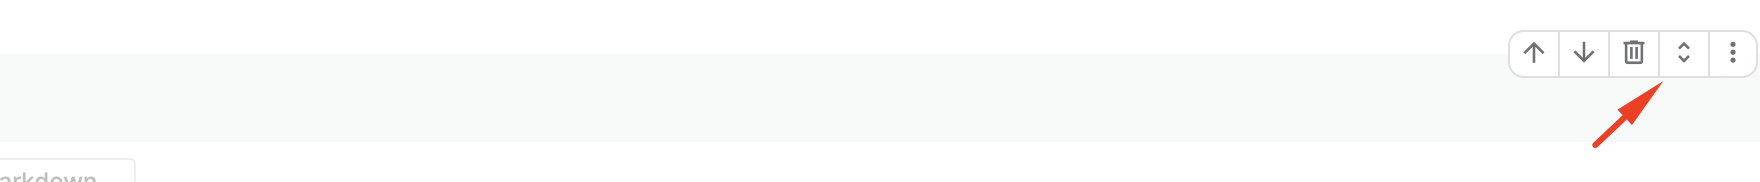

In [ ]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def find_duplicates(data, keys=['sell_id']):
    """
    Расчитывает кол-во дублей в
    датасете, по признакам, переданным в
    качестве аргумента keys функции. 
    Возвращает кол-во дублей.
    :param data: a DataFrame object
    : param keys: a list of string obj values, a names of feature
    :return: an int object, a number of duplicates.
    
    """
    
    shape_before = data.shape[0]
    shape_after = data.drop_duplicates(subset=keys).shape[0]
    
    duplicates_number = shape_before - shape_after
    
    return duplicates_number


def look_at_data(data, type_data):
    """
    Выводит на экран первичную информацию о датасете
    :param type_data: string
    :param data: a DataFrame object
    :return: None
    
    """
    # выявляем признаки с пропусками
    null_df = data.isnull().sum().reset_index()
    null_df.columns = 'col_name null_count'.split(' ')
    null_df = null_df.loc[null_df.null_count > 0]
    
    # report
    print(f"{'Датасет'.ljust(20)} | {type_data.capitalize()}")
    print('-'*34)
    print(f"{'Размерность'.ljust(20)} | {data.shape}")
    print('-'*34)
          

    # find duplicates
    duplicates_number = find_duplicates(data)
    if duplicates_number == 0:
        print(f"{'Дубликаты'.ljust(20)} | нет.")
    else:
        print(f"{'Дубликаты'.ljust(20)} | есть.")
        print('-'*34)
        print(f"{'Кол-во дублей'.ljust(20)} | {duplicates_number} шт.")
    
    print('-'*34)  
    print(f"Пропуски в след. признаках:")
    
    print('-'*34)
    print(f"{'Признак'.ljust(20)} | кол-во, шт.")
    print('-'*34)
    
    for index, row in null_df.iterrows():
        print(f"{row['col_name'].ljust(21)}| {row['null_count']}")
    print('-'*34)
    
    
    display(data.head(3))
    
def find_data_type_discrepancy(train, test):
    """
    Функция ищет различия в типах данных 
    между датасетами и выводит информацию на экран.
    Ничего не возвращает
    :param train: DataFrame object with training data
    :param test: DataFrame object with testing data
    """
    
    train_dtypes_df = train.dtypes.reset_index()
    train_dtypes_df.columns = 'col_name type_train'.split(' ')


    test_dtypes_df = test.dtypes.reset_index()
    test_dtypes_df.columns = 'col_name type_test'.split(' ')


    merged_df = train_dtypes_df.merge(test_dtypes_df, how='outer', left_on='col_name', right_on='col_name')
    merged_df

    print(f"{'Расхождение типов данных:'}")
    print(f"{'Признак'.ljust(21)} | {'train'.ljust(15)} | {'test'.ljust(15)}")
    print('-'*48)

    for index, row in merged_df.iterrows():
        if str(row['type_train']) == 'nan' or str(row['type_test']) == 'nan':
            print(f"{str(row['col_name']).ljust(21)} | {str(row['type_train']).ljust(15)} | {str(row['type_test']).ljust(15)}")

        elif row['type_train'] != row['type_test']:
            print(f"{str(row['col_name']).ljust(21)} | {str(row['type_train']).ljust(15)} | {str(row['type_test']).ljust(15)}")
    
    
# тест -  удалим LTR и так же приведем в 1600, 1800, etc.
def get_correct_engineDisplacement_test(x):
    if x == ' LTR':  # у электроавто объем равен 0 
        return 0
    
    x = float(x.split(' LTR')[0])
    
    return int(x * 1000)


def show_main_feature_metrics(data, feature_name, sampling_type=5, is_plot=True):
    """
    
    """
    if sampling_type == 5:
        samples = "всей"
    elif sampling_type == 1:
        samples = "тренировочной"
        data = data[df.train == 1]
    else:
        samples = "тестовой"
        data = data[df.train == 0]
    
    if is_plot:
        ax = sns.countplot(x=feature_name, data=data) # Распределение значений
        ax.tick_params(axis = 'both', labelsize = 12, labelcolor = 'b', labelrotation = 60)
        plt.title(f'Распределение признака {feature_name} по {samples.upper()} выборке.')
    unique_number_str = f"Number of unique values: {data[feature_name].nunique()}"
    print(unique_number_str)
    print('-' * len(unique_number_str))
    print(f"Top 5 most popular values:")
    if data[feature_name].nunique() >= 5:
        print(data[feature_name].value_counts(normalize=True)[:5])
    else:
        print(data[feature_name].value_counts(normalize=True))
    print('-' * len(unique_number_str))
    print(f"Empty values count: {data[feature_name].isnull().sum()}")
    print(f"Percentage of empty values: {np.round(data[feature_name].isnull().mean(), 2)}")
    
    
def show_barplot(data, feature_name, size=(16,10)):
    """
    :param data: a DataFrame obj
    :param feature_name: a string
    :param size: a tuple of characteristics of a barplot size
    
    """
    
    # plot
    tmp_df = pd.DataFrame(data[feature_name].value_counts()).reset_index().rename(columns={'index':f"{feature_name}_unique_values",
                                                                                feature_name: 'count'})
    
    plt.figure(figsize=size)
    plot = sns.barplot(y='count',x=f"{feature_name}_unique_values", data=tmp_df)
    plot = plt.setp(plot.get_xticklabels(), rotation=45)
    
    
def show_median_barplot(data, col, target, size=(18,4)):
    """
    Выводит на экран медианные значения признака target
    по признаку col.
    :param data: a DataFrame object
    :param col: a string, a name of a categorical feature
    :param target: a string, a name of numerical feature
    """
    plt.figure(figsize=size)
    
    plot = sns.barplot(x=col, y=target, data=data, estimator=median)
    plot.set_title(f"Медианы признака {target.upper()} по признаку {col.upper()}")
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    
    

def get_correct_body_type(name):
    """
    Приводит значения тип кузова к
    унифицированному виду.
    Если значение "тарга" - вернуть "родстер"
    пояснение тут: https://ru.wikipedia.org/wiki/%D0%A2%D0%B0%D1%80%D0%B3%D0%B0
    
    """
    body_types_lst = 'седан|хэтчбек|хэтчбек|внедорожник|купе|родстер|лифтбек|универсал|' +\
                     'кабриолет|компактвэн|пикап|минивэн|микровэн|фургон|лимузин|фастбек'
    
    
    if 'тарга' in name:
        return 'родстер' # маленькое исключение, так как кузов типа тарга представляет собой родстер.
    
    for item in body_types_lst.split('|'): 
        if item in name:
            return item
    
    return name        
        
# для заполнение признака auto_class
def compose_key(row):
    return f"{row['brand']}_{row['model_name']}_{row['bodyType']}"

def fill_class_dict(row):
    """
    Функция получает строку типа series,
    и заполняет словарь class_dict.
    Ничего не возвращает.
    
    """
    
    key = compose_key(row)
    value = row['auto_class']
    
    if key in class_dict:
        return
    class_dict[key] = value
    return

def fill_na_class(row):
    """
    
    """
    key = compose_key(row)
    if key in class_dict:
        row['auto_class'] = class_dict[key]
    return row


# для заполнение признака price_segment
def fill_price_dict(row):
    key = compose_key(row)
    
    if key not in price_segment_dict:
        price_segment_dict[key] = row['price_segment']
    
    return

def fill_na_segment(row):
    """
    
    """
    key = compose_key(row)
    if key in price_segment_dict:
        row['price_segment'] = price_segment_dict[key]
    return row


# для заполнение признака seller_type
def fill_na_seller_from_train(row):
    """
    
    """
    curr_id = row['sell_id']
    
    try:
        value_from_train = train_df[train_df.sell_id == curr_id]
        if not value_from_train.empty:
            row['seller_type'] = value_from_train['seller_type'].iloc[0]
        return row
    except:
        return row      

    
def fill_na_seller_type_from_description(row):
    for item in seller_stop_words:
        if row['description'].find(item) != -1:
            row['seller_type'] = 'COMMERCIAL'
            return row
    
    row['seller_type'] = 'PRIVATE'
    
    return row


# для заполнение признака section
def fill_na_section_from_mileage(row):
    """
    Получает объект типа series,
    Возвращает объект типа series
    """
    mileage = row['mileage']
    prod_date = row['productionDate']
    if (mileage <= 30 and prod_date >= 2018):
        row['section'] = 'new'
    else:
        row['section'] = 'used'    
    
    return row


def get_stat_metrics(s):
    """
    Функция получает объект типа pandas.Series
    Расчитывает основные статистики:
    median - медиана
    perc25, perc75 - нижний и верхний квартили
    IQR - межквартильный размах
    low_border - нижняя граница
    upper_border - верхняя граница
    Возвращает словарь статистических значений.
    """
    q1 = s.quantile(0.25)
    q2 = s.median()
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low_border = q1 - 1.5 * iqr
    upper_border = q3 + 1.5 * iqr
    minimum = s.min()
    maximum = s.max()
    
    names = 'q1 q2 q3 iqr low_border upper_border minimum maximum'.split(' ')
    
    stats = dict(zip(names,
                     [q1, q2, q3, iqr, low_border, \
                      upper_border, minimum, maximum]))
    
    return stats


# Анализ числовых признаков
# Зададим функцию для вывода на экран стат метрик по признаку
def show_stat_data(s):
    """
    Выводит на экран в удобочитаемом виде
    статистические данные.
    Уведомляет о наличии выбросов.
    Рисует гистрограмму распределения признака.
    В случае наличия выбросов, рисует дополнительную
    гистрамму без выбросов.
    """
    
    sd = get_stat_metrics(s) # sd - statistics data
    print(f'[ Признак {s.name} ]')
    print(f"25-й перцентиль: {np.round(sd['q1'], 3)}, медиана: {np.round(sd['q2'], 3)},", \
          f"75-й перцентиль: {np.round(sd['q3'], 3)},", f"IQR: {np.round(sd['iqr'], 3)}.")
    print(f"Границы выбросов: [{np.round(sd['low_border'], 3)}, {np.round(sd['upper_border'], 3)}]")
    print(f"Диапазон значений: [{sd['minimum']}, {sd['maximum']}]")
    
    if (sd['minimum']<sd['low_border']) or (sd['maximum']>sd['upper_border']):
        print(f"В данных имеются выбросы!")
        count_under_low_border = (s < sd['low_border']).sum()
        count_upper_upper_border = (s > sd['upper_border']).sum()
        print(f"Кол-во выбросов:")
        print(f"За пределами нижней границы: {count_under_low_border}")
        print(f"За пределами верхней границы: {count_upper_upper_border}\n")
    else:
        print(f"Выбросов нет\n")

In [ ]:
look_at_data(train, 'train')

In [ ]:
look_at_data(test, 'test')

### Приведение типов ячеек датасетов к одному типу

Помимо признаков, которые есть в тестовом наборе данных, дополнительно собрал следующие фичи:  
- **auto_class** - категориальный признак, обозначающий класс автомобиля ('D', 'C', 'A', 'E', 'S', 'M', 'F', 'J', 'B')
- **price_segment** - категориальный признак, ценовой сегмент авто ('PREMIUM', 'MEDIUM', 'ECONOMY')
- **seller_type** -  категориальный признак, тип продавца ('PRIVATE', 'COMMERCIAL')
- **section** - категориальный признак, состояние авто (new, used)

In [ ]:
# Посмотрим какие признаки отличаются между собой
find_data_type_discrepancy(train, test)

Итак, мы получили перечень наименований признаков, типы данных которых расходятся между тренировочным и тестовым набором.  
Значение **nan** означает, что данного признака до слияния не было в этом датасете.

In [ ]:
# engineDisplacement
# трейн - переводим к формату 1600, 1800, etc.
train.engineDisplacement = train.engineDisplacement.apply(lambda x: (x // 100) * 100)

# тест -  удалим LTR и так же приведем в 1600, 1800, etc.
test.engineDisplacement = test.engineDisplacement.apply(get_correct_engineDisplacement_test)


# enginePower
# приведем признак в тесте в типу данных int64
test.enginePower = test.enginePower.apply(lambda x: int(x.split(' N12')[0]))

# Владельцы
# приведем к типу float64 для совместимости с трейном
test.Владельцы = test.Владельцы.apply(lambda x: x[0]).astype('float64')

# complectation_dict, Владение
# имеют большое кол-во пропусков. Так же значения признака complectation_dict почти полностью
# дублируются в признаке equipment_dict.  Решено удалить оба признака из теста.
test.drop(labels=['complectation_dict', 'Владение'], axis=1, inplace=True)

In [ ]:
# Посмотрим на типы признаков еще раз
find_data_type_discrepancy(train, test)

### Объединение датасетов

In [ ]:
# Добавим метку
train['train'] = 1
test['train'] = 0

df = train.append(test, sort=False).reset_index(drop=True)

In [ ]:
look_at_data(df, 'combined')

Отлично, слияние прошло успешно.  
Однако, теперь мы имеем примерно 22 тыс. дубликатов в данных.  
Это произошло ввиду не большой разницы во времени при парсинге тестового и тренировочного набора данных.  

Получается, что собранный тренировочный набор данных, почти на 40% состоит из данных, которые есть в тесте. Это так же означает, что мы знаем значения таргета почти для 65% тестовых данных.

# EDA
### Категориальные признаки

In [ ]:
# Посмотрим что на текущий момент представляют из себя категориальные признаки с типом данных object
{column: len(df[column].unique()) for column in df.columns if df.dtypes[column] == 'object'}

### Признак bodyType

In [ ]:
show_main_feature_metrics(df, 'bodyType')

Данный признак имеет имеет большое кол-во вариантов указания одинаковых типов кузовов.  
Например, тип кузова "внедорожник" имеет 14 разновидностей в названии.  
Приведу пару примеров:
- 'внедорожник 3 дв. 78''
- 'внедорожник 5 дв. allspace'
- 'внедорожник открытый'  

Аналогично ситуация обстоит и с кузовом седан.  

Решено привести все названия типов кузова к названиям из тестового набора данных, но без указания кол-ва дверей, так как эта информация имеется в отдельном признаке.  
Приведем типы кузовов к следующему виду:  
- 'седан',
- 'внедорожник',
- 'хэтчбек',
- 'купе',
- 'родстер',
- 'лифтбек',
- 'универсал',
- 'кабриолет',
- 'компактвэн'
- и т.д.

In [ ]:
df.bodyType = df.bodyType.apply(get_correct_body_type)

In [ ]:
# Посмотрим на распределение значений признака по всей выборке
show_main_feature_metrics(df, "bodyType")

In [ ]:
show_median_barplot(df[(df.train == 1)], 'bodyType', 'price')

### Выводы по признаку bodyType
Категориальный признак.
Привели различные варианты написания значения признака к единому формату.  
Информативность признака не пострадала, так как информация о кол-ве дверей имеется в виде отдельного признака **numberOfDoors**

В тестовой выборке лидирует седан, он встречается в 38% объявлений.
В тренировочной выборке лидирует внедорожник, он встречается в 40% объявлений.
В общем датасете заметно лидируют 2 типа кузова: Внедорожник и седан.  
Остальные виды кузовов отстают более чем в 3.5 раза.

## Признак brand 

In [ ]:
# Посмотрим на распределение значений признака по всей выборке
show_main_feature_metrics(df, "brand")

In [ ]:
# Посмотрим на барплот распределения марок по тесту
show_barplot(df[df.train == 0], 'brand')

In [ ]:
# Посмотрим на барплот распределения марок по трейну
show_barplot(df[df.train == 1], 'brand')

По барплотам видно, что некоторые марки авто имеют минимальное кол-во объявлений, а точнее меньше 700.  
Стоит протестировать точность модели со всеми марками и без тех, которые имеют минимальное кол-во объявлений.

### Выводы по признаку **brand**:
Категориальный признак, имеет 23 уникальных значения.  
По данным видно, что тестовый набор данных был обрезан по бренду mercedes. В тренировочной выборке, кол-во объявлений по продаже авто этой марки значительно выше.

В трейне по частотности лидирует mercedes с отрывом от бренда bmw почти на 50%
Так же в трейне есть марки, которые выходят за границы частотности марок тестового набора. Пока я их не удаляю, но оставляю на потом вариант протестировать точность модели с ними и без. Например, обрезать марки с частотностью ниже 700.

### Признак fuelType

In [ ]:
# Посмотрим на распределение значений признака по всей выборке
show_main_feature_metrics(df, "fuelType")

Видно, что значение газ занимает не более 0.0003% от общего кол-ва объявлений.  
Проверим есть авто на газу в тестовой выборке

In [ ]:
show_main_feature_metrics(df, "fuelType", sampling_type=0)

In [ ]:
show_median_barplot(df[(df.fuelType == 'бензин') & (df.train == 1)], 'brand', 'price')

Каким то образом в наш Японо-Европейский датасет затесались авто, произведенные в России.  
Удалим их.

In [ ]:
df = df[df.vendor != 'RUSSIAN']

In [ ]:
show_median_barplot(df[(df.fuelType == 'дизель') & (df.train == 1)], 'brand', 'price')

Гибридные авто

In [ ]:
show_main_feature_metrics(df.loc[df.fuelType == 'гибрид'], "brand")

In [ ]:
show_median_barplot(df[(df.fuelType == 'гибрид') & (df.train == 1)], 'brand', 'price')

Электро авто

In [ ]:
show_main_feature_metrics(df.loc[df.fuelType == 'электро'], "brand")

In [ ]:
show_median_barplot(df[(df.fuelType == 'электро') & (df.train == 1)], 'brand', 'price')

In [ ]:
# Узнаем среднюю цену авто по типу топлива и вендору
df[(df.train == 1)].groupby(['fuelType', 'vendor'])[['price']].mean().astype('int64')

### Выводы по признаку fuelType
Категориальный признак.  
Из распределения видно, что лидируют бензиновые двигатели, дизельных двигателей в 5.9 раз меньше, чем бензиновых.  
Остальные типы топлива, а именно гибридные установки, полностью электрические или сжиженный прирогный газ - составляют менее 1%.

Среди гибридных авто лидеры рынка: toyota, lexus, honda  
Среди электро авто лидерами рынка являются: nissan, audi, далее с отрывом идет bmw (отстает от audi более чем в 3 раза)
Среди авто на газу лидер volkswagen, занимет 95% рынка среди легковых авто на газу по всему датасету.  

#### Сравнение медианы цены по признаку fuelType
Среди авто на бензине, медиана цены находится в диапазоне от 250 до 800 тыс.руб.  
Авто следующих марок имеют медиану цены выше среднего, а именно от 1 до 1.5 млн.: audi, bmw, infiniti, jaguar, lexus.   
Медиана цены следующих марок является самой высокой, от 2.3 до 3.4 млн.: mini, mercedes, porsche.  
Медиана цены по всем бензиновым авто составляет 730 тыс. руб.  

Среди дизельных авто медиана цены по всем авто составляет 2.8 млн.руб.  
Гибридные авто имеют медиану цены 1.15 илн.руб.  
Электро авто имеют медиану цены 6.135 млн.руб.  
Авто на газу имеют медиану цены 650 тыс.руб.  
  
Так же результаты группировки по вендору позволили выявить дополнительную зависимость средней цены.  
По всем категориям топлива Европейские авто дороже Японских в 2-7.6 раз.  
Исключение составили авто на газу. Их производят только 2 Европейских производителя.


Стоит использовать полученые данные при feature engineering

### Признак model_name

In [ ]:
show_main_feature_metrics(df, 'model_name')

In [ ]:
# Так как кол-во уникальных значений наименования модели более 800, то посмотрим распределение
# первых 25 самых частотных моделей.
# Посмотрим на барплот распределения признака model_name по всему датасету
first_25_model_names = list(df.model_name.value_counts(ascending=False)[:25].index)
first_25_models_df = df[df.model_name.isin(first_25_model_names)]

show_barplot(first_25_models_df, 'model_name')

In [ ]:
# Посмотрим на барплот распределения признака model_name по тестовой выборке
show_barplot(first_25_models_df[first_25_models_df.train == 0], 'model_name')

### Выводы по признаку model_name
Категориальный признак, имеет 804 юникальных значения. Распределение в тестовой и общей выборке различается.  
Так в тесте топ 5 авто, это:  
- octavia
- 5er
- lancer
- e_klasse
- passat

В общем датасете топ 5 авто, это:
- octavia
- e_klasse
- 5er
- 3er
- polo  

E-KLASSE упал со 2-го места в трейне на 4-е место в тесте, на мой взгляд, связано с тем, как я указывал выше, что при подготовке теста намеренно удалили часть данных по марке mercedes.  

Так же можно с уверенностью сказать, что Octavia, на реальных фактах доказала, что является, народным автомобилем. (При условии сравнения только марок европейского и японского производства)

### Признак numberOfDoors

In [ ]:
show_main_feature_metrics(df, 'numberOfDoors')

In [ ]:
show_median_barplot(df, 'numberOfDoors', 'price')

В наборе данных ест явный выброс по цене, при значении признака кол-во дверей 0.  
Это авто можно признать выбросом, так как оно представлено в единичном экземпляре. Однако это же авто присутсвует в тестовой выборке. Поэтому удалять его не будем.  
Тем не менее временно уберем это авто из анализа и взглянем на барплот медианной цены еще раз. 

In [ ]:
show_median_barplot(df[df.numberOfDoors != 0], 'numberOfDoors', 'price')

### Выводы по признаку numberOfDoors
Категориальный признак. имеет 5 уникальных значений. 
Самым дорогим авто является экземпляр 1904 года производства, который вообще не имеет дверей.  Если исключить этот экземпляр, то по медиане цены лидирует двух дверки, затем 5 дверные авто.

## Признак priceCurrency

In [ ]:
show_main_feature_metrics(df, 'priceCurrency')

In [ ]:
# Данный признак не информативен, удаляем его
df = df.drop('priceCurrency', axis=1)

## Признак vehicleTransmission

In [ ]:
show_main_feature_metrics(df, 'vehicleTransmission')

In [ ]:
# Обнаружили разные способы написания вариаторной трансмиссии. Исправим это.
df.vehicleTransmission = df.vehicleTransmission.replace({'вариатор': 'вариаторная'})

show_main_feature_metrics(df, 'vehicleTransmission')

In [ ]:
show_median_barplot(df, 'vehicleTransmission', 'price')

### Выводы по признаку vehicleTransmission
Категориальный признак. Имеет 4 уникальных значения, с отрывом более чем в 2,5 от механики выделяется автоматическая трансмиссия. Остальные варианты встречаются в 2 раза реже, чем механика.  
При этом медиана цены выше у роботизированной трансмиссии.  
  
Так же обнаружены зависимости по типа трансмиссии и вендора. Например авто с автоматической трансимиссией Европейского производства в 2.7 раза дороже японских аналогов, а авто с варианторной трансмиссией Японского производства в 1,67 раза дороже Европейских аналогов.  

Учтем это при feature engineering

## Признак vendor

In [ ]:
show_main_feature_metrics(df, 'vendor')

In [ ]:
show_median_barplot(df, 'vendor', 'price')

In [ ]:
df[(df.train == 1)][['vendor', 'price']].groupby(['vendor']).mean().astype('int64')

### Выводы по признаку vendor. 
Категориальный признак, имеет 2 значения.  
На боксплоте явно прослеживается связь с целевым признаком. Медиана цены европейских авто выше на 40%, чем японских авто, а вот средняя стоимость европейские авто в 2.1 раза выше японских.  
Видимо европейские авто имеют больший разброс по цене

## Признак Владельцы

In [ ]:
show_main_feature_metrics(df, 'Владельцы')

Посмотрим на авто с пропусками в значении Владельцы. Есть предположение, что это может свидетельствовать на еще не проданный авто с нулевым пробегом.

In [ ]:
df[df.Владельцы.isna()].head(3)

In [ ]:
print(f"Mileage: {df[df.Владельцы.isna()].mileage.unique()}")
print(f"Production Date: {df[df.Владельцы.isna()].productionDate.unique()}")
print(f"Seller_type: {df[df.Владельцы.isna()].seller_type.unique()}")

Догадки подтвердились - пропуски в признаку Владельцы говорят о том, что это новые авто. Этот факт подтверждают так же значения в признака Пробег - 0 км. и Тип продавца - Коммерческий.  
Заполним пропуски признака Владельцы значением 0, то есть владельцев нет и приведет к типу данных 'int64'


In [ ]:
df.Владельцы = df.Владельцы.fillna(value=0).astype('int64')

In [ ]:
show_main_feature_metrics(df, 'Владельцы')

In [ ]:
show_median_barplot(df, 'Владельцы', 'price')

### Выводы по признаку Владельцы
Категориальный признак, имеет 4 уникальных значения.  
Более 40% авто имеют 3 и более владельцев, по 22% авто имеют по 1 и 2 владельца. Новых авто в датесете всего 14%.  
Абсолютно новые авто имеют самую высокую медиану цены, далее, как это и ожидалось, с увеличением кол-ва владельцев цена постепенно снижается.  

Так же группировка по кол-ву владельцев и вендору показывает наличие зависимости.  Во всех случаях европейские авто дороже японских. Учтем это при feature engineering.

## Признак ПТС

In [ ]:
show_main_feature_metrics(df, 'ПТС')

In [ ]:
# Проверим не являются ли новыми авто с пропусками в признаке ПТС
print(f"Mileage: {df[df.ПТС.isna()].mileage.unique()}")
print(f"Production Date: {df[df.ПТС.isna()].productionDate.unique()}")
print(f"Seller_type: {df[df.ПТС.isna()].seller_type.unique()}")
print(f"Types of data: {df[df.ПТС.isna()].train.unique()}")

Как оказалось, пропуски в признаке могут быть связаны с тем, что авто новый и продается коммерческой компанией. Об это свидутельствуют следующие значения:  
- пробег 0 км
- Production Date: 2020 2019 2018
- Тип продавца COMMERCIAL  

Такие записи заполним значением "Оригинал".  

Так же есть одна запись с пробегом 276000 км. Посмотрим на нее внимательнее.


In [ ]:
# Посмотрим на это объявление глазами
df[(df.mileage == 276000) & (df.productionDate == 1999)].car_url.to_list()

Это авто 1999 годав выпуска. Объявление было размещено аж в 2014 году

In [ ]:
# Заполним пропуски значением 'Оригинал'
df.ПТС = df.ПТС.fillna(value='Оригинал')

In [ ]:
show_median_barplot(df, 'ПТС', 'price')

In [ ]:
# Узнаем среднюю цену авто по вендору и кол-ву владельцев
df[(df.train == 1)][['ПТС', 'price']].groupby(['ПТС']).mean().astype('int64')

### Выводы по признаку ПТС
Категориальный признак, имеет 2 уникальных значения. 
Почти все пропуски в признаке являлись новыми авто.  
Признак влияет на кровень цены. Так авто с оригиналами ПТС стоят примерно в 3 раза дороже.


## Признак Привод

In [ ]:
show_main_feature_metrics(df, 'Привод')

In [ ]:
show_median_barplot(df, 'Привод', 'price')

In [ ]:
# Узнаем среднюю цену авто по типу привода
df[(df.train == 1)][['Привод', 'price']].groupby(['Привод']).mean().astype('int64')

In [ ]:
# Узнаем среднюю цену авто по типу привода
df[(df.train == 1)][['Привод', 'vendor', 'price']].groupby(['Привод', 'vendor']).mean().astype('int64')

### Выводы по признаку Привод  
Категориальный признак, имеет 3 уникальных значения.  
В равной степени широко распрастранены 2 типа привода:
- Полный
- Передний

Задний привод встречается в 5 раз реже чем первые 2.  
Срдняя цена на полный привод самая высокая, а вот самая низках цена на переднем приводе.  

## Признак Руль

In [ ]:
show_main_feature_metrics(df, 'Руль')

In [ ]:
# Исправим ошибки написания типов руля
df.Руль = df.Руль.replace({'Левый': 'левый', 'Правый': 'правый'})

In [ ]:
show_main_feature_metrics(df, 'Руль')

In [ ]:
show_median_barplot(df, 'Руль', 'price')

In [ ]:
# Узнаем среднюю цену авто по типу привода
df[(df.train == 1)][['Руль', 'vendor', 'price']].groupby(['Руль', 'vendor']).mean().astype('int64')

### Выводы по признаку Руль 
Категориальный признак, Имеет 2 уникальных значения.  
Значения признака влияют на среднюю цену авто.  Так медиана цены на правый руль находится на уровне 300 тыс. руб., а на левый руль на уровне 900 тыс. руб.

## Признак Состояние

In [ ]:
show_main_feature_metrics(df, 'Состояние')

In [ ]:
# Признак не информативен. Удаляем
df.drop(labels='Состояние', axis=1, inplace=True)

## Признак Таможня

In [ ]:
show_main_feature_metrics(df, 'Таможня')

In [ ]:
# Удаляем
df.drop(labels='Таможня', axis=1, inplace=True)

## Признак auto_class

In [ ]:
show_main_feature_metrics(df, 'auto_class')

Данный признак был собран во время парсинга данных для трейна. Этого признака нет в тесте. В планах заполнить пропуски, используя информацию из трейна.  
Для этого создам словарь, в качестве ключей которого будет строка, состоящая из бренда, модели и модельного года, а значением будет строка значения признака auto_class.

Для справки:  
Одна из принятых [систем классификации классов авто](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%BB%D0%B5%D0%B3%D0%BA%D0%BE%D0%B2%D0%BE%D0%B3%D0%BE_%D0%B0%D0%B2%D1%82%D0%BE%D1%82%D1%80%D0%B0%D0%BD%D1%81%D0%BF%D0%BE%D1%80%D1%82%D0%B0), которую я использую для заполнения пропущенных значений
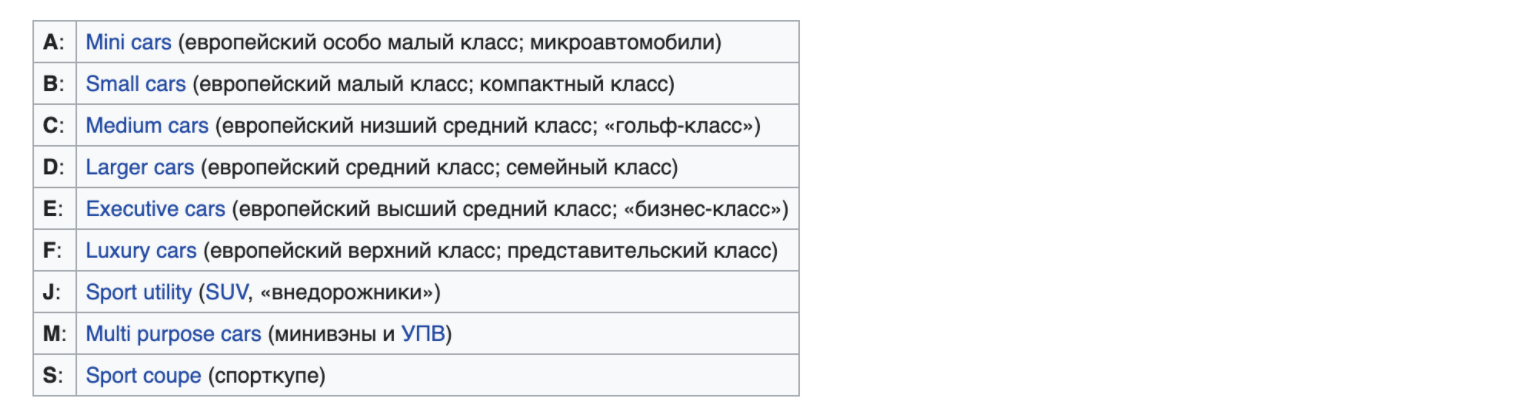

In [ ]:
class_dict = {}

# Заполняем словарь классов авто из данных трейна
start = datetime.now()
for index, row in df[~df.auto_class.isnull()].iterrows():
    fill_class_dict(row)

end = datetime.now()
delta = end - start

print(f"Total time: {(end - start).seconds} sec.")

# Теперь заполним пропуски в признаке
df[df.auto_class.isnull()] = df[df.auto_class.isnull()].apply(fill_na_class, axis=1)

In [ ]:
df.auto_class.isnull().sum()

Удалось заполнить большую часть пропусков в признаке, однако еще 74 строки не удалось заполнить по этим условиям формирования ключа в class_dict.  
Упростим требования к ключу, оставим толькоо марке и модель. Логика здесь следующая: Если выто раньше было в классе S, то маловероятно встретить его в следующее генерации в классе  A или B

In [ ]:
# Перезапишем функцию формирования ключа
def compose_key(row):
    return f"{row['brand']}_{row['model_name']}"

# Обнулим словарь и заполним его новыми ключами
class_dict = {}

start = datetime.now()
for index, row in df[~df.auto_class.isnull()].iterrows():
    fill_class_dict(row)

end = datetime.now()
delta = end - start
print(f"Total time: {(end - start).seconds} sec.")

# Заполним пропуски еще раз
df[df.auto_class.isnull()] = df[df.auto_class.isnull()].apply(fill_na_class, axis=1)
df.auto_class.isnull().sum()

Даже более простой ключ не заполнил все пропуски.  
Так как в пропусках есть так же объекты из теста, обработаем данные в ручном режиме

In [ ]:
# Информация взята из сети интерне: https://ru.wikipedia.org/,  https://auto.ru/catalog/cars/

class_dict['MERCEDES_190_SL'] = 'S'
class_dict['MERCEDES_SIMPLEX'] = 'F'
class_dict['MERCEDES_W186'] = 'F'
class_dict['TOYOTA_COROLLA_II'] = 'C'
class_dict['TOYOTA_SPARKY'] = 'M'
class_dict['TOYOTA_WILL_CYPHA'] = 'C'
class_dict['TOYOTA_WILL'] = 'C'
class_dict['OPEL_GT'] = 'C'
class_dict['OPEL_SUPER_SIX'] = 'D'
class_dict['PEUGEOT_203'] = 'F'
class_dict['MAZDA_B_SERIES'] = 'B'
class_dict['BMW_321'] = 'C'
class_dict['BMW_326'] = 'C'
class_dict['BMW_340'] = 'C'
class_dict['BMW_340'] = 'C'
class_dict['BMW_E3'] = 'C'
class_dict['BMW_M1'] = 'S'
class_dict['BMW_Z1'] = 'S'
class_dict['BMW_X4_M'] = 'J'
class_dict['AUDI_920'] = 'D'
class_dict['AUDI_TT_RS'] = 'S'
class_dict['AUDI_V8'] = 'F'
class_dict['SUBARU_BAJA'] = 'B'
class_dict['SUBARU_STELLA'] = 'B'
class_dict['PORSCHE_356'] = 'S'
class_dict['SKODA_POPULAR'] = 'S'
class_dict['SKODA_120'] = 'B'
class_dict['VOLKSWAGEN_KARMANN_GHIA'] = 'S'
class_dict['VOLKSWAGEN_TYPE_2'] = 'M'
class_dict['SUZUKI_CULTUS'] = 'B'
class_dict['SUZUKI_HUSTLER'] = 'A'
class_dict['LEXUS_RC'] = 'D'
class_dict['MITSUBISHI_SIGMA'] = 'D'
class_dict['CITROEN_DS'] = 'E'

In [ ]:
# Заполним пропуски
df[df.auto_class.isnull()] = df[df.auto_class.isnull()].apply(fill_na_class, axis=1)

После заполнения пропусков с использованием данных из трейна и из внешних источников, посмотрим на признак еще раз

In [ ]:
show_main_feature_metrics(df, 'auto_class')

In [ ]:
show_main_feature_metrics(df, 'auto_class', sampling_type=0)

In [ ]:
show_median_barplot(df, 'auto_class', 'price')

### Выводы по признаку auto_class
Категориальный признак, имеет 9 уникальрных значений.  
Пришлось повозиться при заполнении пропусков. Значимость этого при знака оценим позже.

## Признак price_segment

In [ ]:
show_main_feature_metrics(df, 'price_segment')

Данный признак, так же как и auto_class получен при парсинге данных для обучения модели. Ввиду этого требуется заполнить значение признака в тестовой выборке

In [ ]:
price_segment_dict = {}

start = datetime.now()
for index, row in df[~df.price_segment.isnull()].iterrows():
    fill_price_dict(row)

end = datetime.now()
print(f"Total time: {(end - start).seconds} sec.")

# Заполним пропуски
df[df.price_segment.isnull()] = df[df.price_segment.isnull()].apply(fill_na_segment, axis=1)
print(f"Осталось пропущенных значений: {df.price_segment.isnull().sum()}")

In [ ]:
# в ручном режиме добавить в словарь несколько моделей
price_segment_dict['AUDI_TT_RS'] = 'PREMIUM'
price_segment_dict['AUDI_V8'] = 'PREMIUM'
price_segment_dict['BMW_M1'] = 'PREMIUM'
price_segment_dict['BMW_Z1'] = 'PREMIUM'
price_segment_dict['BMW_X4_M'] = 'PREMIUM'


price_segment_dict['LEXUS_RC'] = 'PREMIUM'

price_segment_dict['MITSUBISHI_SIGMA'] = 'MEDIUM'
price_segment_dict['TOYOTA_SPARKY'] = 'MEDIUM'
price_segment_dict['TOYOTA_WILL_CYPHA'] = 'MEDIUM'
price_segment_dict['TOYOTA_WILL'] = 'MEDIUM'

In [ ]:
# Заполним пропуски
df[df.price_segment.isnull()] = df[df.price_segment.isnull()].apply(fill_na_segment, axis=1)
print(f"Осталось пропущенных значений: {df.price_segment.isnull().sum()}")

In [ ]:
show_main_feature_metrics(df, 'price_segment')

In [ ]:
show_median_barplot(df, 'price_segment', 'price')

In [ ]:
df[(df.train == 1)].groupby(['price_segment', 'vendor'])[['price']].mean().astype('int64')

### Выводы по признаку price_segment
Категориальный признак, имеет всегоо 3 уникальных значения.  
Как и ожидалось, значение признака сильно влияет на медиану цены.  
Так Премиальный сегмент имеет медиану на уровне 2 млн. руб. Остальные варианты значений признака отстают от премиума почта в 3.5 раза.   


Так же обнаружена интересная зависимость от типа вендора. Так в эконом и премиальном классах Европейские авто дороже Японских, но в среднем классе ситуация меняется. Стоит это отобразить при feature engineering

## Признак seller_type

In [ ]:
show_main_feature_metrics(df, 'seller_type')

In [ ]:
# Посмотрим влияет ли этот признак на среднюю цену авто
df[(df.train == 1)].groupby(['brand', 'seller_type'])[['price']].mean().astype('int64')

Данные, полученные после группировки, говорят, что средняя стоимость авто зависит от типа признака seller_type.  
Потому этот признак стоит сохранить.  

### ЗАПОЛНЕНИЕ ПРОПУСКОВ
ШАГ 1  
Заполним пропуски в тесте из данных, которые есть в трейне по sell_id. Так мы сможем значительно сократить кол-во пропусков, так как примерно 64% данных из теста есть в трейне.
Так удасться сократить кол-во операций, необходимых для заполнения оставшихся пропусков.  Если это будет дополнительный пасрсинг данных, то он пройдет значительн обыстрее, так как  большая часть пропусков уже будет заполнена.

In [ ]:
# Приведем признак description, из которого будем по ключам определять тип продавца, к нижнему регистру
df.description = df.description.str.lower()

In [ ]:
# Стоп слова, обозначающие коммерческого продавца
seller_stop_words = ['ЛОТ:', 'Автопрага Север', 'ГК FAVORIT MOTORS', 'Вы можете получить скидку', 'покупка в кредит',
    'бесплатный тест-драйв', 'Преимущества автокредитования:', 'ежедневно без выходных',
    '2-й Вязовский проезд', 'РАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ', 'Первоначальный взнос',
    'Trade-In', 'Записаться на тест-драйв', 'Автомобиль продается официальным дилером',
    'Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ', 'В наличии более',
    'ВЫГОДА при покупке а/м в кредит', 'СРОЧНЫЙ ВЫКУП авто', 'ВЫГОДА при обмене',
    'ГК АВТОМИР', 'ГК «АВТОМИР»', 'Наша компания', 'при обмене на Ваш автомобиль',
    'кредит без первоначального взноса', 'Выкуп кредитных автомобилей', 'Комиссионная продажа',
    'Аукцион', 'FAVORIT MOTORS Сadillac/Chevrolet Север', 'Дополнительная скидка до',
    'Выгода по программе Trade-In', 'Выгода в кредит', 'бесплатный тест-драйв',
    'РОЛЬФ - Официальный дилер', 'Уникальный код автомобиля:', 'Только для клиентов AVILON',
    'КАСКО не обязательно', 'специалистов автоцентра', 'Автомобиль представлен MAJOR EXPERT ',
    '17 торговых точек', '15 лет на рынке', 'более 3000 автомобилей с пробегом в наличии',
    'Предпродажная подготовка', 'Лизинг для юр.и физ.лиц', 'Подберем для Вас самый выгодный вариант',
    'СКИДКА НА ВЫБРАННЫЙ АВТОМОБИЛЬ', 'Автомобиль представлен в автосалоне', 'Наши сотрудники',
    'Кредит от', 'оформление автомобиля в кредит', 'В наличии более', 'Ждём вас ежедневно',
    'AVILON Автомобили с пробегом', 'Уникальный код автомобиля:', 'Безопасная покупка в АСЦ/ЧЕСТНО',
    'АвтоСпецЦентр Каширка – официальный дилерский центр', 'В состав АСЦ входят',
    'Покупка у нас – правильный выбор!', 'РОЛЬФ ЯСЕНЕВО с пробегом', 'Выгода до',
    'Выгода при покупке в кредит', 'В наличии более', 'Срочный выкуп', 'оформление автомобиля в кредит',
    'авто в Trade-In', 'дарим набор подарков', 'КАСКО не обязательно',
    'ДОПОЛНИТЕЛЬНАЯ СКИДКА НА ВЫБРАННЫЙ АВТОМОБИЛЬ', 'Атлант-М Тушино - официальный дилер Skoda',
    'Каждый автомобиль проходит', 'Срочный выкуп', 'Комиссионная продажа', 'Продажа в кредит',
    '10 Банков-партнеров', 'РОЛЬФ - Официальный дилер', 'Все автомобили прошли:',
    'Специальные предложения', 'Гарантированная выгода', 'АвтоГЕРМЕС уже более 20 лет',
    'Автомобиль прошел комплексную предпродажную подготовку', 'Гаражный номер:',
    'ГК БИЗНЕС КАР – сеть официальных дилерских центров', 'Дополнительная  скидка',
    'Работаем ежедневно', 'Преимущества автокредитования', 'сертифицированные Das WeltAuto',
    'Ждём вас ежедневно']

# приведем их к нижнему регистру и удалим дубли
seller_stop_words =  list(set([item.lower() for item in seller_stop_words]))

In [ ]:
df[df.seller_type.isnull()] = df[df.seller_type.isnull()].apply(fill_na_seller_type_from_description, axis=1)

In [ ]:
show_main_feature_metrics(df, 'seller_type')

In [ ]:
show_median_barplot(df, 'seller_type', 'price')

### Выводы по признаку seller_type
Категориальный признак, имеет 2 уникальных значения, медиана цены при значении COMMERCIAL примерно в 4.2 раза выше чем при значении PRIVATE.

## Признак section

In [ ]:
show_main_feature_metrics(df, 'section')

In [ ]:
# Посмотрим в каких датасетах имеются пропуски
df[df.section.isnull()].train.value_counts()

### Заполним пропуски
Первоначально была идея заполнить пропуски по тесту из ссылки на объявление, но после дополнительного анализа данных, пришел к выводу, что так делать не стоит. Точечный аналих рандомно выбранных объявлений показал, что в описании говорится, что авто новый, данные пробега это подтверждают (не более 11 км), но в ссылке указана категория used.  
Предполагаю, что диллеры намеренно указываю наличие хотя бы минимального пробега и добавляют объявление в категорию "С проегом". Так они пытаются перехвать тех клиентов, кто зашел посмотреть на бу авто.  
Лучше ориентироваться на пробег. Заполним пропуски из расчета, что пробег до 30 км при годе выпуска не позже 2018 г. - является признаком нового авто.

In [ ]:
df[df.section.isnull()] = df[df.section.isnull()].apply(fill_na_section_from_mileage, axis=1)

In [ ]:
show_main_feature_metrics(df, 'section')

In [ ]:
show_median_barplot(df, 'section', 'price')

### Выводы по признаку section
Категориальный признак. Имеет 2 уникальных значения.  
Авто с пробегом в 6 раз больше, чем новых авто. при этом Медиана цена на новые авто примерно в 6 раз выше чем на авто с пробегом.  
Как мне кажется, данный признак достаточно сильно скоррелирован с признаком seller_type.  
Вывод по нему отложим до момента анализа матрицы корреляций.

## Признак color

In [ ]:
show_main_feature_metrics(df, 'color')

Видно, что некоторые названия цветов имеют несколько вариантов написания, например черный цвет написан двумя способами через букву е и через букву ё.  
Так же бежевый цвет написан с точкой и без.  
Исправим

In [ ]:
df.color = df.color.replace({'чёрный': 'черный', 'бежевый.': 'бежевый'})

In [ ]:
# Распределение цветов по общему датасету
show_main_feature_metrics(df, "color")

In [ ]:
show_median_barplot(df, 'color', 'price')

### Выводы по признаку color:
Категориальный признак.
Всего 16 уникальных цветов.  
Из данного признака в последствии будет сгенерировано 16 dummy-признаков.  

Топ 4 самых распрастраненных цвета:  
- черный
- белый
- серебристый
- серый

## Анализ числовых признаков
- engineDisplacement
- enginePower
- mileage
- modelDate
- productionDate
- price

In [ ]:
num_cols = 'engineDisplacement enginePower mileage modelDate productionDate'.split(' ')

In [ ]:
# скаткая сводна основных стат данных отдельноо по трейне и тесту
for col in num_cols:
    print('Train:')
    show_stat_data(df[df.train == 1][col])
    print('Test:')
    show_stat_data(df[df.train == 0][col])
    print('#'*50)

In [ ]:
df[num_cols].describe()

In [ ]:
# Распределение данных
for i in num_cols:
    plt.figure(figsize=(25,11))
    sns.distplot(df[i][df[i] > 0], kde = False, rug=False)
    plt.title(f"признак {i}")
    plt.show()

In [ ]:
numerical_df = df[df.train == 1][['engineDisplacement','enginePower', 'mileage', 'modelDate', 'productionDate', 'price']]
sns.pairplot(numerical_df, kind = 'reg')

# Feature engineering

Без генерации новых признаков, лишь обработав большую часть данных, имеющихся в датасете, получили score=13.81 (CatBoost).  
Добавим к данным результаты группировки данных по категориальным признакам.

Для начала добавим несколько новых признаков, являющимися производными от уже имеющихся. Это такие признаки как:
- минимальная стоимость по кат. признаку
- максимальная стоимость по кат. признаку
- средняя стоимость по кат. признаку
- медианная стоимость по кат. признаку

Так же стоит добавить новые признаки, которые будут является результатом группировки по нескольким кат.признакам, например:
- минимальная цена по типу кузова и вендору
- максимальная цена по типу кузова и вендору
- средняя цена по типу кузова и вендору
- медианная цена по типу кузова и вендору  

Забегая вперед скажу, что группировка и заполение только по категориальном упризнаку заняла более 6-7 часов.  
Поэтому второй вариант группировки так и не сделал, но собираюсь вернуться к этой идеи позже.

In [ ]:
num_cols_to_pivot = num_cols + ['price']

### Группировка по 1 признаку

In [ ]:
bodyType_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['bodyType'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

brand_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['brand'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

fuelType_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['fuelType'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

model_name_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['model_name'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

numberOfDoors_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['numberOfDoors'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

vehicleTransmission_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['vehicleTransmission'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

vendor_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['vendor'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

owners_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['Владельцы'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

pts_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['ПТС'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

gear_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['Привод'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

steering_wheel_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['Руль'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

auto_class_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['auto_class'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

price_segment_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['price_segment'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

seller_type_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['seller_type'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

section_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['section'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

color_pivot = pd.pivot_table(df[df.train == 1], values=num_cols_to_pivot, index=['color'],
                                aggfunc=[np.min, np.max, np.mean, np.median, np.std])

In [ ]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'vendor',
           'Владельцы', 'ПТС', 'Привод', 'Руль', 'auto_class', 'price_segment', 'seller_type', 'section', 'color']
agg_funcs = ['amin', 'amax', 'mean', 'median', 'std']
num_cols_to_pivot = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'price']

pivots_list = [bodyType_pivot, brand_pivot, fuelType_pivot, model_name_pivot, numberOfDoors_pivot,
              vehicleTransmission_pivot,vendor_pivot,  owners_pivot, pts_pivot, gear_pivot,
              steering_wheel_pivot, auto_class_pivot, price_segment_pivot, seller_type_pivot,
              section_pivot, color_pivot]

In [ ]:
# Зададим функцию создания новых признаков в df, заполненныхnp.nan
def create_new_features(df, cat_cols, agg_funcs, num_cols):
    for cat_col in cat_cols:
        for agg_func in agg_funcs:
            for num_col in num_cols:
                new_feature = f"{cat_col}_{agg_func}_{num_col}"
                df[new_feature] = np.nan
                
    return df

In [ ]:
# Создадим новые признаки
df = create_new_features(df, cat_cols, agg_funcs, num_cols_to_pivot)

In [ ]:
# Функция заполнения данными из pivot-таблицы
def fill_cols_from_pivot(row, col_name, pivot_table, agg_funcs, num_cols):
    """
    Получает строку из датафрейма, и список кортежей data_list, 
    состоящий из названия признака и ссылки на 
    соответсвующий pivot table
    [(col_name1, pivot_table1), (col_name1, pivot_table12), ..].
    Заполняет соответсвующие ячейки данными из pivot_table
    
    """
    
    col_value = row[col_name]
    
    for agg_func in agg_funcs:
        for num_col in num_cols:
            new_col_name = f"{col_name}_{agg_func}_{num_col}"
            try:
                row[new_col_name] = pivot_table.loc[col_value][agg_func, num_col]
            except:
                print(f"Failed: {new_col_name}")
                continue
                
    return row
    

In [ ]:
# соединим названия признаков и соответсвующие им сводные таблицы
data_list = list(zip(cat_cols, pivots_list))

In [ ]:
# Процесс заполнения значениями из сводных таблиц занимает более 6-7 часов, поэтому закомментирован.
# Результат заполнения сохранен в csv-файл.
# Для ускорения проверки работы запустите код из ячейки ниже, чтобы получить датафрейм с заполненными данными


# Заполним их значениями
# for col_name, pivot_table in data_list:
#     df = df.apply(fill_cols_from_pivot, axis=1, col_name=col_name, pivot_table=pivot_table,
#                   agg_funcs=agg_funcs, num_cols=num_cols_to_pivot)
    
# # Созраним на всякий случай промежуточный результат, так как обработка занимает очень много времени
# df.to_csv('intermediate_data_2.csv', index=False)

In [ ]:
# Считаем датасет с уже заполненными данными
df = pd.read_csv('../input/intermediate-data/intermediate_data_2.csv', low_memory=False)
df.shape

In [ ]:
# Посмотрим по каким колонкам есть пропуски из только что созданных
look_at_data(df, 'new_data')

Получили несколько пропусков данных.  
Определим названия признаков и заполним из среним значением.

In [ ]:
null_df = df.isnull().sum().reset_index()
null_df.columns = 'col_name null_count'.split(' ')
null_df = null_df.loc[null_df.null_count > 0]
num_cols_with_na_lst = null_df.col_name.to_list()[5:]

df[num_cols_with_na_lst] = df[num_cols_with_na_lst].fillna(df[num_cols_with_na_lst].mean())

In [ ]:
# Посмотрим на данные еще раз после заполнения
look_at_data(df, 'new_data')

In [ ]:
# Удалим из данных признаки, которые я обрабатывать пока не стану:
df.drop(labels=['description', 'equipment_dict', 'url_saleid', 'car_url', 'image', 'model_info',
                'name', 'super_gen', 'vehicleConfiguration'], axis=1, inplace=True)
df.shape

### Группировка по 2 признакам
Как уже упомянул выше, пока не стал делать двойную группировку, так как оченб большие накладные расходы.  
Оставляю это раздел как задел на будущее.

In [ ]:
# Ввиду того, что для заполнения данными из сводных таблиц уходит очень много времени, пока не стану заполнять
# с группировкой по нескольким признакам.

# Пример группировки по признаку bodyType и vendor
# bodyType_vendor_pivot = pd.pivot_table(df, values=num_cols_to_pivot, index=['bodyType', 'vendor'],
#                                 aggfunc=[np.min, np.max, np.mean, np.median])
# bodyType_vendor_pivot

## Признак equipment_dict
Имеет более 22 тыс. пропусков. В настоящий момент решил не обрабатывать его, однако оставляю раздел на будущее.  
При этом признак достаточно сложный для обработки и заполнения пропусков, так как имеет 25% nan-ов.  


Представляет из себя структурированную строку, из которой можно получить дополнительные признаки.  
Для начала пройдемся по всем записям, чтобы получить все возможные значения.  
Далее создадим новые признаки и будем по порядку их заполнять.

In [ ]:
# df.equipment_dict.to_list()[0]

In [ ]:
# equipment_set = set()

# def parse_equipment(s):
#     tmp_strings = s.replace('{', '') \
#                    .replace('}', '') \
#                    .replace('"', '').split(', ')
#     values = [item.split(':')[0].replace("'", '') for item in tmp_strings]
#     equipment_set.update(set(values))


# start = datetime.now()
# for ind, row in df[~df.equipment_dict.isnull()].iterrows():
#     parse_equipment(row['equipment_dict'])
    
# end = datetime.now()
# print(f"Total time: {(end - start).seconds} sec.")

In [ ]:
# print(f"Всего получено {len(equipment_set)} значений:\n{equipment_set}")

На мой взгляд 322 значения - слишком уж много, да и что может означать значия типа 301, 4R3 и т.д. не очень понятно.  
Поэтому собрал свой список значений, которые хоть как то можно интерпретировать. Он в 2 раза короче, но, как мне кажется содержит важную информацию.

In [ ]:
# equipment_cols = ['airbag-driver', 'airbag-passenger', 'airbag-side', 'airbag-rear-side', 'airbag-curtain',
#              'knee-airbag', 'isofix', 'isofix-front', 'asr', 'esp', 'bas', 'hsa', 'abs', 'glonass',
#              'drive-mode-sys', 'power-child-locks-rear-doors', 'tyre-pressure', 'drowsy-driver-alert-system',
#              'laminated-safety-glass', 'lane-keeping-assist', 'blind-spot', 'night-vision',
#              'collision-prevention-assist', 'traffic-sign-recognition', 'vsm', 'hdc', 'aux', 'android-auto',
#              'bluetooth', 'apple-carplay', 'usb', 'audiopreparation', 'audiosystem-cd', 'music-super',
#              'audiosystem-tv', 'wireless-charger', 'voice-recognition', 'entertainment-system-for-rear-seat-passengers',
#              'navigation', '12v-socket', '220v-socket', 'ya-auto', 'auto-cruise', 'wheel-power', 'computer',
#              'remote-engine-start', 'power-latching-doors', 'start-button', '360-camera', 'rear-camera',
#              'front-camera', 'climate-control-1', 'climate-control-2', 'multizone-climate-control', 'condition',
#              'cruise-control', 'multi-wheel', 'easy-trunk-opening', 'cooling-box', 'park-assist-r', 'park-assist-f',
#              'steering-wheel-gear-shift-paddles', 'ashtray-and-cigarette-lighter', 'programmed-block-heater',
#              'projection-display', 'wheel-configuration1', 'wheel-configuration2', 'adj-pedals', 'wheel-memory',
#              'start-stop-function', 'auto-park', 'keyless-entry', 'electronic-gage-panel', 'electro-mirrors',
#              'electro-trunk', 'e-adjustment-wheel', 'auto-mirrors', 'electro-window-back', 'electro-window-front',
#              'alcantara', 'velvet-seats', 'rear-seat-heat-vent', 'front-seats-heat-vent', 'decorative-interior-lighting',
#              'sport-pedals', 'eco-leather', 'leather', 'seats-2', 'seats-4', 'seats-5', 'seats-6', 'seats-7',
#              'combo-interior', 'servo', 'door-sill-panel', 'wheel-heat', 'wheel-leather', 'leather-gear-stick',
#              'black-roof', 'seat-memory', 'driver-seat-memory', 'panorama-roof', 'front-centre-armrest',
#              'rear-seats-heat', 'front-seats-heat', 'passenger-seat-updown', 'driver-seat-updown', 'light-interior',
#              'massage-seats', 'folding-tables-rear', 'roller-blind-for-rear-window', 'roller-blinds-for-rear-side-windows',
#              'sport-seats', 'fabric-seats', 'tinted-glass', 'third-rear-headrest', 'third-row-seats', 'dark-interior',
#              'folding-front-passenger-seat', 'electro-rear-seat', 'driver-seat-electric', 'volume-sensor', 'immo',
#              'alarm', 'feedback-alarm', 'lock', 'automatic-lighting-control', 'rain-sensor', 'light-sensor', 'drl',
#              'xenon', 'laser-lights', 'light-cleaner', 'ptf', 'led-lights', 'adaptive-light', 'high-beam-assist',
#              'windscreen-heat', 'windcleaner-heat', 'airbrush', 'body-mouldings', '14-inch-wheels', '15-inch-wheels',
#              '16-inch-wheels', '17-inch-wheels', '18-inch-wheels', '19-inch-wheels', '20-inch-wheels', '21-inch-wheels',
#              '22-inch-wheels', 'alloy-wheel-disks', 'paint-metallic', 'body-kit', 'roof-rails', 'steel-wheels',
#              'activ-suspension', 'reduce-spare-wheel', 'air-suspension', 'spare-wheel', 'sport-suspension']

In [ ]:
# # Создадим новые признаки из equipment_cols и заполним из nan
# for col in equipment_cols:
#     df[col] = np.nan

# df.shape

In [ ]:
# # Теперь нужно заполнить значениями для тех объектов, которые имеют значение в признаке equipment_dict
# def fill_equipment_from_dict(row):
    
#     for col in equipment_cols:
#         if col in row['equipment_dict']:
#             row[col] = 1
#         else:
#             row[col] = 0


#             start = datetime.now()            
# df[~df.equipment_dict.isnull()] = df[~df.equipment_dict.isnull()].apply(fill_equipment_from_dict, axis=1)

# end = datetime.now()
# print(f"Total time: {(end - start).seconds} sec.")

## Подготовка к обучению моделей

In [ ]:
# Удалил из кат. признаков model_name - так как прироста точности модели не дает
cat_cols = ['bodyType', 'brand', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'vendor',
           'Владельцы', 'ПТС', 'Привод', 'Руль', 'auto_class', 'price_segment', 'seller_type', 'section', 'color']

num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate'] + df.columns.to_list()[25:505]

target_col = ['price']
service_cols = ['sell_id', 'train']

In [ ]:
# Отберем только обработанные признаки
data = df[cat_cols + num_cols + service_cols + target_col].copy()

# Пробуем сделать логарифмирование тергета
data['price'] = data['price'].apply(lambda w: np.log(w + 1))

y = data[data.train == 1]['price']
data.drop('price', axis=1, inplace=True)  # Удалим таргет из данных

In [ ]:
# Убедимся, что пропусков нет
look_at_data(data, 'data')

### Логарифмирование, нормализация и ohe-кодирование

In [ ]:
# логарифмирование
for col in num_cols:
    data[col] = data[col].apply(lambda w: np.log(w + 1))
    
# нормирование
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ohe-encoding
data = pd.get_dummies(data, columns=cat_cols)
data.shape

# Train Split

In [ ]:
# Разделим выборки
X = data.query('train == 1').drop(['train', 'sell_id'], axis=1)
X_sub = data.query('train == 0').drop(['train', 'sell_id'], axis=1)

In [ ]:
# Создадим транировочную и валидационную выборки из трейна
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Models

## Model 1: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.

In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [ ]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

## Model 2 : CatBoost

In [ ]:
# Keep list of all categorical features in dataset to specify this for CatBoost
cat_features = X_train.columns[485:]

In [ ]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         # cat_features=cat_features_ids,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

In [ ]:
model.save_model('catboost_single_model_baseline.model')

In [ ]:
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

CatBoost показал score=11.81409 на лидерборде

### Model 3: RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators=2000, max_features = 300,
                              bootstrap=True,
                              random_state=RANDOM_SEED,
                              n_jobs=-1,
                              verbose=2)
model.fit(X_train, y_train)
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

В процессе тестирования были получены следующие результаты при разных значениях параметров:
- n_estimators=100, score=10.32503
- n_estimators=250, score=10.23876
- n_estimators=2000, max_features = 300, score=9.92099

### model 4: BaggingRegressor с RandomForestRegressor

In [ ]:
rfr_model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rfr_model.fit(X_train, y_train)

model = BaggingRegressor(rfr_model, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Были получены следующие результаты:
- score=11.49077

### Model 5: LinearRegression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Были получены следующие результаты:
- score = 17.34311

### Model 6: ExtraTreeRegressor 

In [ ]:
model = ExtraTreeRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Были получены следующие результаты:
- score=10.98682

### Model 7: BaggingRegressor

In [ ]:
extra_tree = ExtraTreeRegressor(random_state=RANDOM_SEED)
model = BaggingRegressor(extra_tree, random_state=RANDOM_SEED).fit(X_train, y_train)
print(f"reg score: {model.score(X_test, y_test)}")
      
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Были получены следующие результаты:
- score=10.98682

### Model 8: GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=250)
model.fit(X_train, y_train)
predict = model.predict(X_test)


# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Были получены следующие результаты:
- score=15.16891

### Model 9: Stacking with RandomForestRegressor
Будем брать среднее.

In [ ]:
models = [RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in tqdm(d_models):
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = y_pred               
    return d_df

temp_df = stacking_model_predict(models, X_train, y_train, X_test)
temp_df['y_pred']=temp_df.mean(axis=1)

predict = np.array(temp_df['y_pred'])

# # оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

In [ ]:
# Обучим еще раз теперь на всем датасете
temp_df = stacking_model_predict(models, X, y, X_sub)
temp_df['y_pred']=temp_df.mean(axis=1)

predict = np.array(temp_df['y_pred'])

Были получены следующие результаты:
- score=9.20080

Стекинг показывает самый лучший результат, который мне пока удалось достич.  
Попробуем его улучшить путем изменения параметров моделей

In [ ]:
# При n_estimators=2000 - происходит переполение оперативное памяти. Процес прерывается.
models = [RandomForestRegressor(n_estimators=1000, max_features = 300,
                                random_state=RANDOM_SEED, n_jobs=-1, verbose=2),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), n_estimators=500,
                          random_state=RANDOM_SEED, n_jobs=-1, verbose=2)]


def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in tqdm(d_models):
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = y_pred               
    return d_df


temp_df = stacking_model_predict(models, X, y, X_sub)
temp_df['y_pred']=temp_df.mean(axis=1)

predict = np.array(temp_df['y_pred'])

Были получены следующие результаты:
- RFR: n_estimators=1000, max_features = 300, score=9.14954  
- RFR: n_estimators=1500, max_features=400, score=9.15337  
- RFR: n_estimators=500, max_features=300, score=9.15337  
- RFR: n_estimators=1000, max_features=200, score=9.16983  
- RFR: n_estimators=1000, max_features=300 + ETR: n_estimators=100, score=8.88966  
- RFR: n_estimators=1000, max_features=300 + ETR:  n_estimators=500, score=8.86488 - THE BEST SCORE

### Подбор параметров случайного леса
Выполнить подбор оптимальных параметров с помощью RandomizedSearchCV не удалось, так как происходило переполнение оперативной памяти, поэтому код закомментирован.


In [ ]:
# n_estimators = [int(x) for x in np.linspace(start = 250, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf, 
#                                param_distributions=random_grid, 
#                                n_iter=100, 
#                                cv=3, 
#                                verbose=1, 
#                                random_state=RANDOM_SEED, 
#                                n_jobs=-1)
# rf_random.fit(X_train, y_train)
# rf_random.best_params_

# Submission

In [ ]:
# predict_submission = model.predict(X_sub)  # для всех моделей кроме  stacking_model

# Обратное преобразование стоимости в
predict_submission = np.exp(predict) - 1

# округлим предикт, так как очень редко встречаются цены имеющие остаток при делении на 1000
predict_submission = (predict_submission // 1000) * 1000


In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

# Выводы
Достаточно интересный проект. В процессе его выполнения решил большоое кол-во задач, связанных с парсингом, обработкой данных, а так же построению моделей и их доводке.  
Все это, безусловно, позволило лучше понять основы Data Science и обозначило слабые места в ужченных знаниях.  

Стал лучше понимать какие признаки требуеются модели при feature engineering. 
До создания и наполения датасета результата  уровневой группировки по категориальным признакам, метрика была на уровне 25%, и только эти сгенерированные признаки дали хороший прирост в точности.  

Что не сделано:
- не работал с признаком equipmentDict
- не использовал работу с текстом в признаке description

Первоначальная ставка CatBoost не оправдал себя. Модель оказалась менее точной, чем stacking с RandomForestRegressor и ExtraTreeRegressor.  

Если кому то этот notebook покажется полезным, то попрошу его оценить на удобной для вас платформе (Kaggle, GitHub)